In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import plotly
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()
from datetime import date, datetime
import holidays
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

#confirm this works
from scipy.special import inv_boxcox

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

In [2]:
# lmp_data = pd.read_csv('data/processed/price_data.csv')
# lmp_data['datetime_beginning_utc'] = pd.to_datetime(lmp_data['datetime_beginning_utc'])
# lmp_data['datetime_beginning_ept'] = pd.to_datetime(lmp_data['datetime_beginning_ept'])

In [58]:
mw_data = pd.read_csv('data/processed/mw_data.csv')
mw_data['datetime_beginning_utc'] = pd.to_datetime(mw_data['datetime_beginning_utc'])
mw_data['datetime_beginning_ept'] = pd.to_datetime(mw_data['datetime_beginning_ept'])

In [59]:
mw_data.head()

datetime_beginning_utc datetime_beginning_ept  pepco_mw  total_outages_mw  \
0    2016-01-02 00:00:00    2016-01-01 19:00:00  2960.829            6544.0   
1    2016-01-02 01:00:00    2016-01-01 20:00:00  2916.155            6544.0   
2    2016-01-02 02:00:00    2016-01-01 21:00:00  2869.052            6544.0   
3    2016-01-02 03:00:00    2016-01-01 22:00:00  2767.395            6544.0   
4    2016-01-02 04:00:00    2016-01-01 23:00:00  2659.245            6544.0   

   planned_outages_mw  maintenance_outages_mw  forced_outages_mw   enthalpy  \
0              1537.0                  4168.0              839.0  12.362294   
1              1537.0                  4168.0              839.0  11.875585   
2              1537.0                  4168.0              839.0  11.558347   
3              1537.0                  4168.0              839.0  11.343696   
4              1537.0                  4168.0              839.0  11.038527   

   apparentTemperature  dewPoint  humidity  humidity_ratio    DD  CDD   HDD  \
0                38.87     25.84      0.59        0.002813  1.09  0.0  1.09   
1                37.42     24.87      0.60        0.002686  1.15  0.0  1.15   
2                36.21     24.69      0.63        0.002663  1.20  0.0  1.20   
3                35.51     24.35      0.64        0.002620  1.23  0.0  1.23   
4                34.17     24.48      0.67        0.002637  1.28  0.0  1.28   

   uvIndex  peak_hour  
0      0.0          1  
1      0.0          1  
2      0.0          1  
3      0.0          1  
4      0.0          0

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
def print_metrics(y_true, y_pred):
    """
    prints mean squared error, mean absolute error and mean absolute percentage error
    """
    print('MSE: ', round(mean_squared_error(y_true, y_pred),2))
    print('MAE: ', round(mean_absolute_error(y_true, y_pred),2))
    print('MAPE: ', round(mean_absolute_percentage_error(y_true, y_pred),2),'%')  

In [7]:
def init_prophet_model(regressors=[], holidays=False, model=Prophet()):
    """
    initializes a prophet model.
    adds regressors from a list of column names to be used as regressors.
    includes holidays if holidays=True
    """
    m = model
    if len(regressors) > 0:
        for reg in regressors:
            m.add_regressor(reg)
    if holidays == True:
        m.add_country_holidays(country_name='US')
    return m

In [8]:
def prophet_df(df, time, target, regressors=[]):
    """
    prepares dataframe for use with prophet based on
    specified time series, target and regressors
    """
    df_prep = df.copy()
    df_prep.rename(columns={time: 'ds', target: 'y'}, inplace=True)
    df_prep = df_prep[['ds', 'y']+regressors]
    return df_prep

# baseline no regressors

In [10]:
# initializing baseline model
m_mw = init_prophet_model()

In [11]:
# generating the properly formatted dataframe for use with prophet
# and one for predicting
df_mw = prophet_df(mw_data, 'datetime_beginning_ept', 'pepco_mw')
pred_mw = df_mw.drop(columns=['y']).copy()

In [12]:
# fitting the baseline model
m_mw.fit(df_mw);

In [13]:
fcst_mw = m_mw.predict(pred_mw)

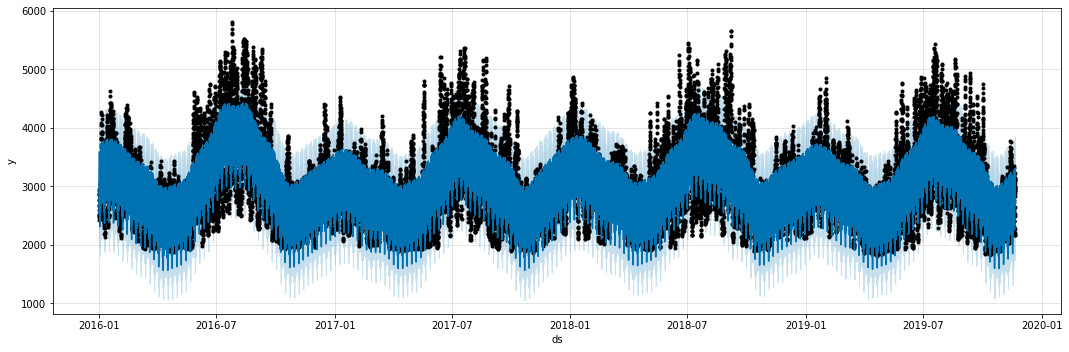

In [14]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_mw.plot(fcst_mw, ax=ax)

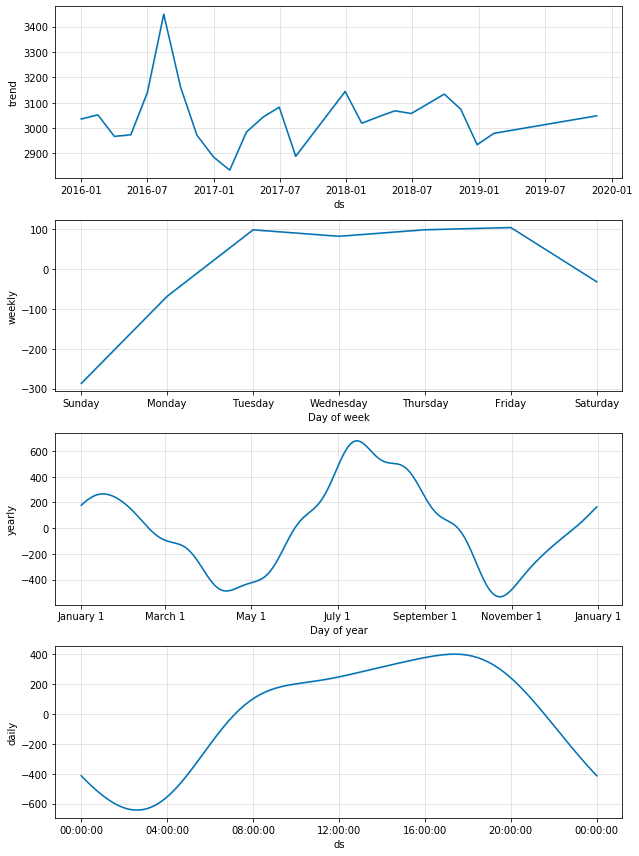

In [15]:
fig = m_mw.plot_components(fcst_mw)

In [16]:
compare_mw = fcst_mw.set_index('ds')[['yhat',
                                        'yhat_lower',
                                        'yhat_upper']].join(df_mw.set_index('ds'))

In [17]:
print_metrics(compare_mw['y'], compare_mw['yhat'])

MSE:  151126.11
MAE:  300.48
MAPE:  9.8 %


# baseline with regressors

In [65]:
# creating list of all possible regressors for use as baseline model
mw_base_reg = list(mw_data.iloc[:,3:].columns)

In [75]:
# initializing baseline model
m_mw_base = init_prophet_model(mw_base_reg,
                               model=Prophet(changepoint_prior_scale = 0.4))

In [76]:
# generating the properly formatted dataframe for use with prophet
# and one for predicting
df_mw_base = prophet_df(mw_data, 'datetime_beginning_ept', 'pepco_mw', mw_base_reg)
pred_mw_base = df_mw_base.drop(columns=['y']).copy()

In [77]:
# fitting the baseline model
m_mw_base.fit(df_mw_base);

In [78]:
fcst_mw_base = m_mw_base.predict(pred_mw_base)

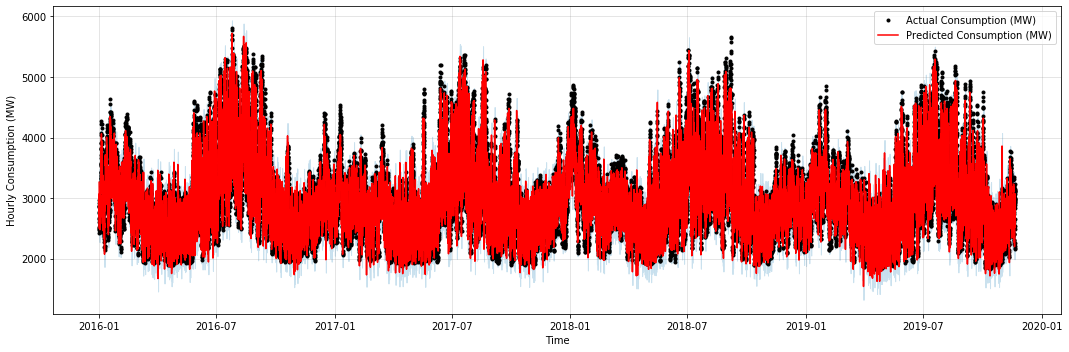

In [79]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_mw_base.plot(fcst_mw_base, xlabel='Time', ylabel='Hourly Consumption (MW)', ax=ax)
plt.gca().get_lines()[1].set_color("red")
plt.gca().get_lines()[0].set_label("Actual Consumption (MW)")
plt.gca().get_lines()[1].set_label("Predicted Consumption (MW)")
plt.legend();
plt.savefig('img/MW_Predictions.png');

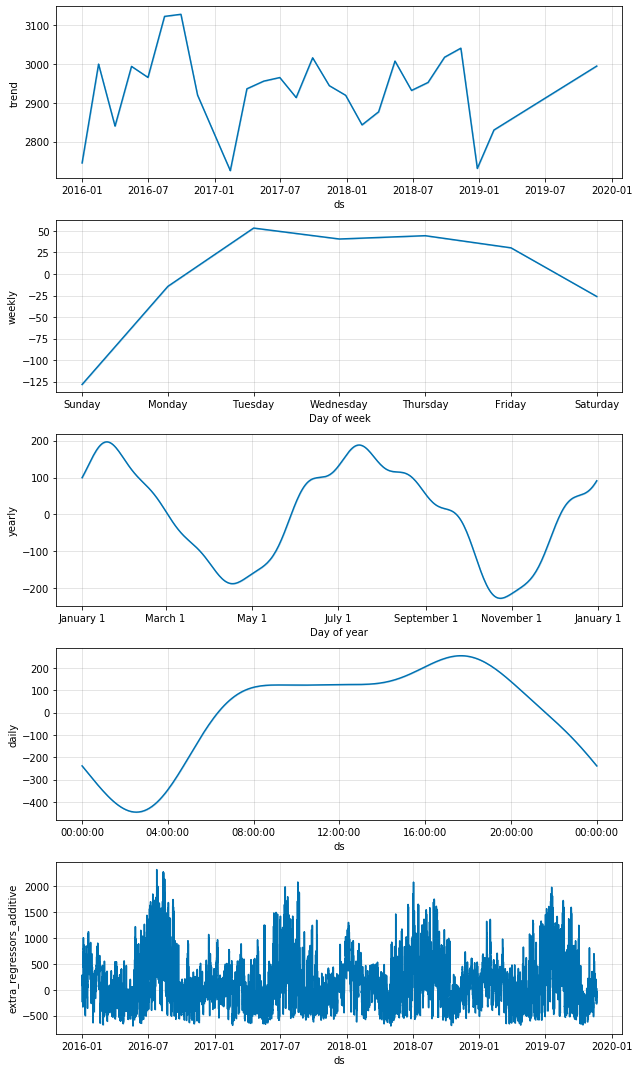

In [80]:
fig = m_mw_base.plot_components(fcst_mw_base)

In [81]:
compare_mw_base = fcst_mw_base.set_index('ds')[['yhat',
                                                'yhat_lower',
                                                'yhat_upper']].join(df_mw_base.set_index('ds'))

In [82]:
print_metrics(compare_mw_base['y'], compare_mw_base['yhat'])

MSE:  27558.42
MAE:  130.01
MAPE:  4.41 %


In [30]:
print_metrics(compare_mw_base['y'], compare_mw_base['yhat'])

MSE:  28690.12
MAE:  132.14
MAPE:  4.49 %


# with transformations too

In [35]:
# creating list of all possible regressors for use as baseline model
mw_sel_reg = list(mw_data.iloc[:,6:].columns)

In [36]:
# initializing baseline model
m_mw_trans = init_prophet_model(mw_sel_reg, model=Prophet())

In [37]:
# generating the properly formatted dataframe for use with prophet
# and one for predicting
df_mw_trans = prophet_df(mw_data, 'datetime_beginning_ept', 'pepco_mw', mw_sel_reg)

In [38]:
pred_mw_trans = df_mw_trans.drop(columns=['y']).copy()

In [39]:
yj_mw = PowerTransformer(method='yeo-johnson')

orig_mw_y = df_mw_trans['y'].copy()
pre_trans_mw_y = np.array(orig_mw_y).reshape(-1, 1)
transformed_y = yj_mw.fit_transform(pre_trans_mw_y)
df_mw_trans['y'] = transformed_y

In [40]:
# fitting the baseline model
m_mw_trans.fit(df_mw_trans);

In [41]:
fcst_mw_trans = m_mw_trans.predict(pred_mw_trans)

In [42]:
# inverse transforming the y's
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_mw_trans[column] = yj_mw.inverse_transform(np.array(fcst_mw_trans[column]).reshape(-1, 1))
m_mw_trans.history['y'] = yj_mw.inverse_transform(np.array(m_mw_trans.history['y']).reshape(-1, 1))
df_mw_trans['y'] = orig_mw_y

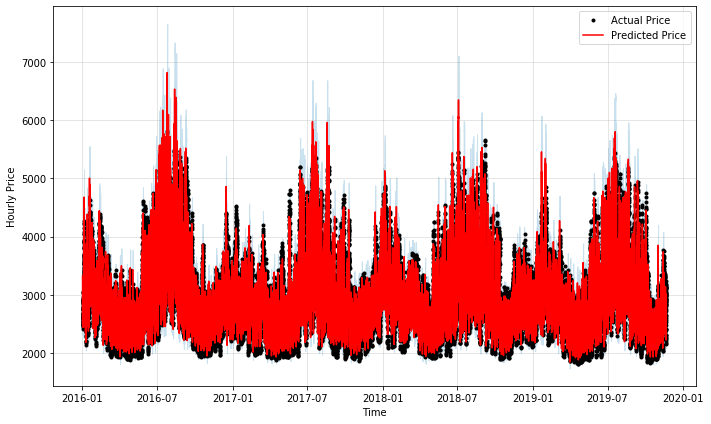

In [43]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(10)
fig = m_mw_trans.plot(fcst_mw_trans, xlabel='Time', ylabel='Hourly Price', uncertainty=True, ax=ax)
plt.gca().get_lines()[1].set_color("red")
plt.gca().get_lines()[0].set_label("Actual Price")
plt.gca().get_lines()[1].set_label("Predicted Price")
plt.legend();
# plt.savefig('img/MW_Predictions.png');
# ax.fill_between(fcst_lmp_trans['ds'], fcst_lmp_trans['yhat_lower'], fcst_lmp_trans['yhat_upper'], color='yellow', alpha=0.5)
# fig = plot_plotly(m_lmp_trans, fcst_lmp_trans, xlabel='Time', ylabel='Hourly Price', uncertainty=True)
# py.iplot(fig)

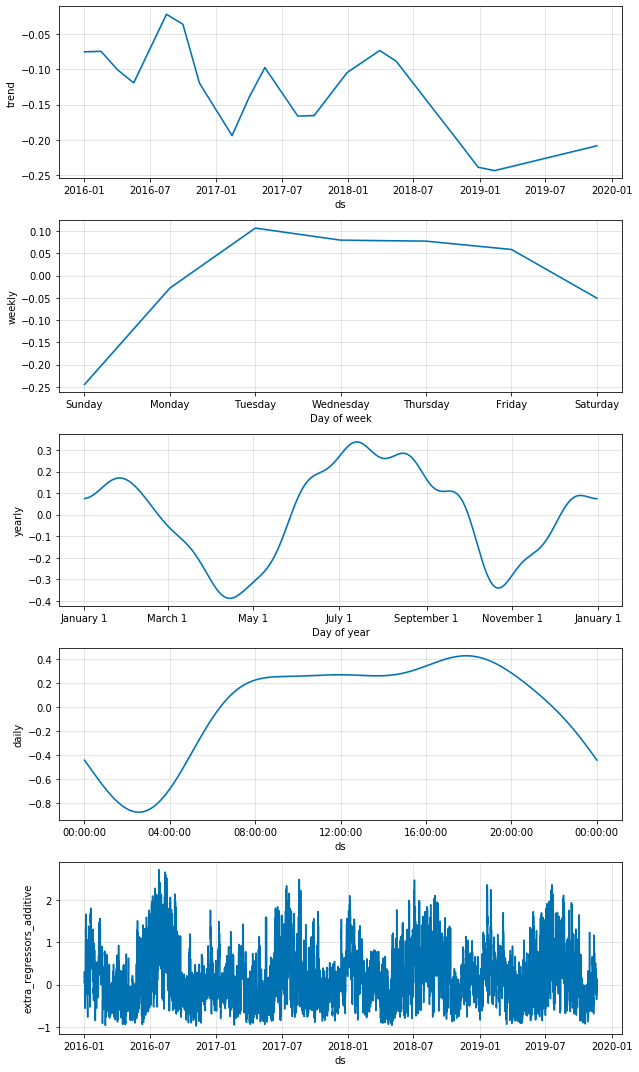

In [44]:
fig = m_mw_trans.plot_components(fcst_mw_trans)

In [45]:
compare_mw_trans = fcst_mw_trans.set_index('ds')[['yhat',
                                                  'yhat_lower',
                                                  'yhat_upper']].join(df_mw_trans.set_index('ds'))

In [46]:
print_metrics(compare_mw_trans['y'], compare_mw_trans['yhat'])

MSE:  36990.07
MAE:  147.68
MAPE:  4.87 %


# Individual Components

# Looping for feature selection

In [52]:
list(mw_data.iloc[:,3:].columns)

['total_outages_mw',
 'planned_outages_mw',
 'maintenance_outages_mw',
 'forced_outages_mw',
 'enthalpy',
 'apparentTemperature',
 'dewPoint',
 'DD',
 'CDD',
 'HDD',
 'uvIndex',
 'peak_hour']

In [50]:
core_reg = []
consider_reg = [[],
                ['DD',
                 'CDD',
                 'HDD',
                 'uvIndex',
                 'peak_hour'],
                ['DD',
                 'uvIndex',
                 'peak_hour'],
                ['CDD',
                 'HDD',
                 'uvIndex',
                 'peak_hour'],
                ['DD',
                 'CDD',
                 'HDD',
                 'uvIndex',
                 'peak_hour',
                 'forced_outages_mw'],
                ['DD',
                 'CDD',
                 'HDD',
                 'uvIndex',
                 'peak_hour',
                 'enthalpy'],
                ['DD',
                 'CDD',
                 'HDD',
                 'uvIndex',
                 'peak_hour',
                 'apparentTemperature'],
                ['DD',
                 'CDD',
                 'HDD',
                 'uvIndex',
                 'peak_hour',
                 'dewPoint']
                ]
reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_mw_test = init_prophet_model(test, model=Prophet())

    df_mw_test = prophet_df(
        mw_data, 'datetime_beginning_ept', 'pepco_mw', test)
    pred_mw_test = df_mw_test.drop(columns=['y']).copy()

#     yj_mw = PowerTransformer(method='yeo-johnson')
#     orig_mw_y = df_mw_test['y'].copy()
#     pre_trans_mw_y = np.array(orig_mw_y).reshape(-1, 1)
#     transformed_y = yj_mw.fit_transform(pre_trans_mw_y)
#     df_mw_test['y'] = transformed_y

    m_mw_test.fit(df_mw_test)
    fcst_mw_test = m_mw_test.predict(pred_mw_test)

#     for column in ['yhat', 'yhat_lower', 'yhat_upper']:
#         fcst_mw_test[column] = yj_mw.inverse_transform(
#             np.array(fcst_mw_test[column]).reshape(-1, 1))
#     df_mw_test['y'] = orig_mw_y
    compare_mw_test = fcst_mw_test.set_index('ds')[['yhat',
                                                    'yhat_lower',
                                                    'yhat_upper']].join(df_mw_test.set_index('ds'))

    print(test)
    print_metrics(compare_mw_test['y'], compare_mw_test['yhat'])

[]
MSE:  151126.11
MAE:  300.48
MAPE:  9.8 %
['DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour']
MSE:  33747.23
MAE:  143.03
MAPE:  4.9 %
['DD', 'uvIndex', 'peak_hour']
MSE:  51617.35
MAE:  178.77
MAPE:  6.12 %
['CDD', 'HDD', 'uvIndex', 'peak_hour']
MSE:  33760.76
MAE:  143.07
MAPE:  4.9 %
['DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour', 'forced_outages_mw']
MSE:  33219.41
MAE:  142.15
MAPE:  4.87 %
['DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour', 'enthalpy']
MSE:  30944.81
MAE:  137.26
MAPE:  4.69 %
['DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour', 'apparentTemperature']
MSE:  33773.6
MAE:  143.11
MAPE:  4.9 %
['DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour', 'dewPoint']
MSE:  33122.56
MAE:  141.66
MAPE:  4.86 %


In [51]:
core_reg = []
consider_reg = [['CDD',
                 'HDD',
                 'uvIndex',
                 'peak_hour',
                 'forced_outages_mw',
                 'enthalpy'],
                ['DD',
                 'CDD',
                 'HDD',
                 'uvIndex',
                 'peak_hour',
                 'forced_outages_mw',
                 'enthalpy'],
                ['forced_outages_mw',
                 'enthalpy',
                 'dewPoint',
                 'DD',
                 'CDD',
                 'HDD',
                 'uvIndex',
                 'peak_hour'],
                ['forced_outages_mw',
                 'enthalpy',
                 'dewPoint',
                 'CDD',
                 'HDD',
                 'uvIndex',
                 'peak_hour'],
                ['forced_outages_mw',
                 'enthalpy',
                 'apparentTemperature',
                 'dewPoint',
                 'DD',
                 'CDD',
                 'HDD',
                 'uvIndex',
                 'peak_hour']
                ]
reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_mw_test = init_prophet_model(test, model=Prophet())

    df_mw_test = prophet_df(
        mw_data, 'datetime_beginning_ept', 'pepco_mw', test)
    pred_mw_test = df_mw_test.drop(columns=['y']).copy()

#     yj_mw = PowerTransformer(method='yeo-johnson')
#     orig_mw_y = df_mw_test['y'].copy()
#     pre_trans_mw_y = np.array(orig_mw_y).reshape(-1, 1)
#     transformed_y = yj_mw.fit_transform(pre_trans_mw_y)
#     df_mw_test['y'] = transformed_y

    m_mw_test.fit(df_mw_test)
    fcst_mw_test = m_mw_test.predict(pred_mw_test)

#     for column in ['yhat', 'yhat_lower', 'yhat_upper']:
#         fcst_mw_test[column] = yj_mw.inverse_transform(
#             np.array(fcst_mw_test[column]).reshape(-1, 1))
#     df_mw_test['y'] = orig_mw_y
    compare_mw_test = fcst_mw_test.set_index('ds')[['yhat',
                                                    'yhat_lower',
                                                    'yhat_upper']].join(df_mw_test.set_index('ds'))

    print(test)
    print_metrics(compare_mw_test['y'], compare_mw_test['yhat'])

['CDD', 'HDD', 'uvIndex', 'peak_hour', 'forced_outages_mw', 'enthalpy']
MSE:  30502.62
MAE:  136.44
MAPE:  4.67 %
['DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour', 'forced_outages_mw', 'enthalpy']
MSE:  30477.86
MAE:  136.39
MAPE:  4.66 %
['forced_outages_mw', 'enthalpy', 'dewPoint', 'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour']
MSE:  29394.22
MAE:  133.94
MAPE:  4.55 %
['forced_outages_mw', 'enthalpy', 'dewPoint', 'CDD', 'HDD', 'uvIndex', 'peak_hour']
MSE:  29409.28
MAE:  133.97
MAPE:  4.55 %
['forced_outages_mw', 'enthalpy', 'apparentTemperature', 'dewPoint', 'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour']
MSE:  29411.12
MAE:  133.99
MAPE:  4.55 %


In [55]:
core_reg = ['forced_outages_mw', 'enthalpy', 'dewPoint',
            'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour']
consider_reg = [['total_outages_mw',
                'planned_outages_mw',
                'maintenance_outages_mw'],
               ['total_outages_mw',
                'maintenance_outages_mw']]
reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_mw_test = init_prophet_model(test, model=Prophet())

    df_mw_test = prophet_df(
        mw_data, 'datetime_beginning_ept', 'pepco_mw', test)
    pred_mw_test = df_mw_test.drop(columns=['y']).copy()

    m_mw_test.fit(df_mw_test)
    fcst_mw_test = m_mw_test.predict(pred_mw_test)

    compare_mw_test = fcst_mw_test.set_index('ds')[['yhat',
                                                    'yhat_lower',
                                                    'yhat_upper']].join(df_mw_test.set_index('ds'))

    print(test)
    print_metrics(compare_mw_test['y'], compare_mw_test['yhat'])

['forced_outages_mw', 'enthalpy', 'dewPoint', 'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour', 'total_outages_mw', 'planned_outages_mw', 'maintenance_outages_mw']
MSE:  28678.45
MAE:  132.11
MAPE:  4.49 %
['forced_outages_mw', 'enthalpy', 'dewPoint', 'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour', 'total_outages_mw', 'maintenance_outages_mw']
MSE:  28686.92
MAE:  132.13
MAPE:  4.49 %


In [61]:
core_reg = ['total_outages_mw',
            'planned_outages_mw',
            'maintenance_outages_mw',
            'forced_outages_mw',
            'enthalpy',
            'apparentTemperature',
            'dewPoint',
            'DD',
            'CDD',
            'HDD',
            'uvIndex',
            'peak_hour']
consider_reg = [['humidity'],
                ['humidity_ratio'],
               ['humidity',
                'humidity_ratio']]
reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_mw_test = init_prophet_model(test, model=Prophet())

    df_mw_test = prophet_df(
        mw_data, 'datetime_beginning_ept', 'pepco_mw', test)
    pred_mw_test = df_mw_test.drop(columns=['y']).copy()

    m_mw_test.fit(df_mw_test)
    fcst_mw_test = m_mw_test.predict(pred_mw_test)

    compare_mw_test = fcst_mw_test.set_index('ds')[['yhat',
                                                    'yhat_lower',
                                                    'yhat_upper']].join(df_mw_test.set_index('ds'))

    print(test)
    print_metrics(compare_mw_test['y'], compare_mw_test['yhat'])

['total_outages_mw', 'planned_outages_mw', 'maintenance_outages_mw', 'forced_outages_mw', 'enthalpy', 'apparentTemperature', 'dewPoint', 'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour', 'humidity']
MSE:  28421.17
MAE:  131.65
MAPE:  4.48 %
['total_outages_mw', 'planned_outages_mw', 'maintenance_outages_mw', 'forced_outages_mw', 'enthalpy', 'apparentTemperature', 'dewPoint', 'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour', 'humidity_ratio']
MSE:  27807.87
MAE:  130.6
MAPE:  4.43 %
['total_outages_mw', 'planned_outages_mw', 'maintenance_outages_mw', 'forced_outages_mw', 'enthalpy', 'apparentTemperature', 'dewPoint', 'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour', 'humidity', 'humidity_ratio']
MSE:  27786.78
MAE:  130.56
MAPE:  4.43 %


In [62]:
changepoint_prior_scale = [0.05, 0.15, 0.25, 0.4, 0.55, 0.75]
seasonality_prior_scale = [0.05, 0.15, 0.25, 0.4, 0.55, 0.75]
core_reg = ['total_outages_mw',
            'planned_outages_mw',
            'maintenance_outages_mw',
            'forced_outages_mw',
            'enthalpy',
            'apparentTemperature',
            'dewPoint',
            'DD',
            'CDD',
            'HDD',
            'uvIndex',
            'peak_hour',
            'humidity',
            'humidity_ratio']

# creating list of all possible regressors for use as baseline model
for item in changepoint_prior_scale:
    m_mw_test = init_prophet_model(
        core_reg, model=Prophet(changepoint_prior_scale=item))

    df_mw_test = prophet_df(
        mw_data, 'datetime_beginning_ept', 'pepco_mw', core_reg)
    pred_mw_test = df_mw_test.drop(columns=['y']).copy()

    m_mw_test.fit(df_mw_test)
    fcst_mw_test = m_mw_test.predict(pred_mw_test)

    compare_mw_test = fcst_mw_test.set_index('ds')[['yhat',
                                                    'yhat_lower',
                                                    'yhat_upper']].join(df_mw_test.set_index('ds'))

    print('changepoint_prior_scale: ', item)
    print_metrics(compare_mw_test['y'], compare_mw_test['yhat'])

for item in seasonality_prior_scale:
    m_mw_test = init_prophet_model(
        core_reg, model=Prophet(seasonality_prior_scale=item))

    df_mw_test = prophet_df(
        mw_data, 'datetime_beginning_ept', 'pepco_mw', core_reg)
    pred_mw_test = df_mw_test.drop(columns=['y']).copy()

    m_mw_test.fit(df_mw_test)
    fcst_mw_test = m_mw_test.predict(pred_mw_test)

    compare_mw_test = fcst_mw_test.set_index('ds')[['yhat',
                                                    'yhat_lower',
                                                    'yhat_upper']].join(df_mw_test.set_index('ds'))

    print('seasonality_prior_scale: ', item)
    print_metrics(compare_mw_test['y'], compare_mw_test['yhat'])

changepoint_prior_scale:  0.05
MSE:  27786.78
MAE:  130.56
MAPE:  4.43 %
changepoint_prior_scale:  0.15
MSE:  27600.43
MAE:  130.11
MAPE:  4.41 %
changepoint_prior_scale:  0.25
MSE:  27600.02
MAE:  130.1
MAPE:  4.41 %
changepoint_prior_scale:  0.4
MSE:  27559.04
MAE:  130.01
MAPE:  4.41 %
changepoint_prior_scale:  0.55
MSE:  27618.23
MAE:  130.13
MAPE:  4.41 %
changepoint_prior_scale:  0.75
MSE:  27626.46
MAE:  130.15
MAPE:  4.41 %
seasonality_prior_scale:  0.05
MSE:  27792.44
MAE:  130.58
MAPE:  4.43 %
seasonality_prior_scale:  0.15
MSE:  27780.28
MAE:  130.55
MAPE:  4.43 %
seasonality_prior_scale:  0.25
MSE:  27757.55
MAE:  130.49
MAPE:  4.42 %
seasonality_prior_scale:  0.4
MSE:  27785.73
MAE:  130.56
MAPE:  4.43 %


KeyboardInterrupt: 

In [63]:
changepoint_prior_scale = [0.3, 0.35, 0.4, 0.45, 0.5]
seasonality_prior_scale = [0.2, 0.25, 0.3, 0.35]
core_reg = ['total_outages_mw',
            'planned_outages_mw',
            'maintenance_outages_mw',
            'forced_outages_mw',
            'enthalpy',
            'apparentTemperature',
            'dewPoint',
            'DD',
            'CDD',
            'HDD',
            'uvIndex',
            'peak_hour',
            'humidity',
            'humidity_ratio']

# creating list of all possible regressors for use as baseline model
for item in changepoint_prior_scale:
    m_mw_test = init_prophet_model(
        core_reg, model=Prophet(changepoint_prior_scale=item))

    df_mw_test = prophet_df(
        mw_data, 'datetime_beginning_ept', 'pepco_mw', core_reg)
    pred_mw_test = df_mw_test.drop(columns=['y']).copy()

    m_mw_test.fit(df_mw_test)
    fcst_mw_test = m_mw_test.predict(pred_mw_test)

    compare_mw_test = fcst_mw_test.set_index('ds')[['yhat',
                                                    'yhat_lower',
                                                    'yhat_upper']].join(df_mw_test.set_index('ds'))

    print('changepoint_prior_scale: ', item)
    print_metrics(compare_mw_test['y'], compare_mw_test['yhat'])

for item in seasonality_prior_scale:
    m_mw_test = init_prophet_model(
        core_reg, model=Prophet(seasonality_prior_scale=item))

    df_mw_test = prophet_df(
        mw_data, 'datetime_beginning_ept', 'pepco_mw', core_reg)
    pred_mw_test = df_mw_test.drop(columns=['y']).copy()

    m_mw_test.fit(df_mw_test)
    fcst_mw_test = m_mw_test.predict(pred_mw_test)

    compare_mw_test = fcst_mw_test.set_index('ds')[['yhat',
                                                    'yhat_lower',
                                                    'yhat_upper']].join(df_mw_test.set_index('ds'))

    print('seasonality_prior_scale: ', item)
    print_metrics(compare_mw_test['y'], compare_mw_test['yhat'])

changepoint_prior_scale:  0.3
MSE:  27614.43
MAE:  130.12
MAPE:  4.41 %
changepoint_prior_scale:  0.35
MSE:  27585.36
MAE:  130.06
MAPE:  4.41 %
changepoint_prior_scale:  0.4
MSE:  27559.04
MAE:  130.01
MAPE:  4.41 %
changepoint_prior_scale:  0.45
MSE:  27612.62
MAE:  130.12
MAPE:  4.41 %
changepoint_prior_scale:  0.5
MSE:  27590.73
MAE:  130.07
MAPE:  4.41 %
seasonality_prior_scale:  0.3
MSE:  27778.79
MAE:  130.54
MAPE:  4.43 %
seasonality_prior_scale:  0.35
MSE:  27863.0
MAE:  130.75
MAPE:  4.43 %
seasonality_prior_scale:  0.4
MSE:  27785.73
MAE:  130.56
MAPE:  4.43 %


KeyboardInterrupt: 

In [64]:
# changepoint_prior_scale = [0.3, 0.35, 0.4, 0.45, 0.5]
seasonality_prior_scale = [0.2, 0.25, 0.3, 0.35]
core_reg = ['total_outages_mw',
            'planned_outages_mw',
            'maintenance_outages_mw',
            'forced_outages_mw',
            'enthalpy',
            'apparentTemperature',
            'dewPoint',
            'DD',
            'CDD',
            'HDD',
            'uvIndex',
            'peak_hour',
            'humidity',
            'humidity_ratio']

# creating list of all possible regressors for use as baseline model
# for item in changepoint_prior_scale:
#     m_mw_test = init_prophet_model(
#         core_reg, model=Prophet(changepoint_prior_scale=item))

#     df_mw_test = prophet_df(
#         mw_data, 'datetime_beginning_ept', 'pepco_mw', core_reg)
#     pred_mw_test = df_mw_test.drop(columns=['y']).copy()

#     m_mw_test.fit(df_mw_test)
#     fcst_mw_test = m_mw_test.predict(pred_mw_test)

#     compare_mw_test = fcst_mw_test.set_index('ds')[['yhat',
#                                                     'yhat_lower',
#                                                     'yhat_upper']].join(df_mw_test.set_index('ds'))

#     print('changepoint_prior_scale: ', item)
#     print_metrics(compare_mw_test['y'], compare_mw_test['yhat'])

for item in seasonality_prior_scale:
    m_mw_test = init_prophet_model(
        core_reg, model=Prophet(seasonality_prior_scale=item))

    df_mw_test = prophet_df(
        mw_data, 'datetime_beginning_ept', 'pepco_mw', core_reg)
    pred_mw_test = df_mw_test.drop(columns=['y']).copy()

    m_mw_test.fit(df_mw_test)
    fcst_mw_test = m_mw_test.predict(pred_mw_test)

    compare_mw_test = fcst_mw_test.set_index('ds')[['yhat',
                                                    'yhat_lower',
                                                    'yhat_upper']].join(df_mw_test.set_index('ds'))

    print('seasonality_prior_scale: ', item)
    print_metrics(compare_mw_test['y'], compare_mw_test['yhat'])

seasonality_prior_scale:  0.2
MSE:  27778.7
MAE:  130.54
MAPE:  4.43 %
seasonality_prior_scale:  0.25
MSE:  27757.55
MAE:  130.49
MAPE:  4.42 %
seasonality_prior_scale:  0.3
MSE:  27778.79
MAE:  130.54
MAPE:  4.43 %
seasonality_prior_scale:  0.35
MSE:  27863.0
MAE:  130.75
MAPE:  4.43 %


In [74]:
# changepoint_prior_scale = [0.3, 0.35, 0.4, 0.45, 0.5]
seasonality_prior_scale = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
core_reg = ['total_outages_mw',
            'planned_outages_mw',
            'maintenance_outages_mw',
            'forced_outages_mw',
            'enthalpy',
            'apparentTemperature',
            'dewPoint',
            'DD',
            'CDD',
            'HDD',
            'uvIndex',
            'peak_hour',
            'humidity',
            'humidity_ratio']

# creating list of all possible regressors for use as baseline model
# for item in changepoint_prior_scale:
#     m_mw_test = init_prophet_model(
#         core_reg, model=Prophet(changepoint_prior_scale=item))

#     df_mw_test = prophet_df(
#         mw_data, 'datetime_beginning_ept', 'pepco_mw', core_reg)
#     pred_mw_test = df_mw_test.drop(columns=['y']).copy()

#     m_mw_test.fit(df_mw_test)
#     fcst_mw_test = m_mw_test.predict(pred_mw_test)

#     compare_mw_test = fcst_mw_test.set_index('ds')[['yhat',
#                                                     'yhat_lower',
#                                                     'yhat_upper']].join(df_mw_test.set_index('ds'))

#     print('changepoint_prior_scale: ', item)
#     print_metrics(compare_mw_test['y'], compare_mw_test['yhat'])

for item in seasonality_prior_scale:
    m_mw_test = init_prophet_model(
        core_reg, model=Prophet(seasonality_prior_scale=item, changepoint_prior_scale=0.4))

    df_mw_test = prophet_df(
        mw_data, 'datetime_beginning_ept', 'pepco_mw', core_reg)
    pred_mw_test = df_mw_test.drop(columns=['y']).copy()

    m_mw_test.fit(df_mw_test)
    fcst_mw_test = m_mw_test.predict(pred_mw_test)

    compare_mw_test = fcst_mw_test.set_index('ds')[['yhat',
                                                    'yhat_lower',
                                                    'yhat_upper']].join(df_mw_test.set_index('ds'))

    print('seasonality_prior_scale: ', item)
    print_metrics(compare_mw_test['y'], compare_mw_test['yhat'])

seasonality_prior_scale:  0.05
MSE:  27563.4
MAE:  130.03
MAPE:  4.41 %
seasonality_prior_scale:  0.1
MSE:  27600.78
MAE:  130.1
MAPE:  4.41 %
seasonality_prior_scale:  0.15
MSE:  27626.13
MAE:  130.15
MAPE:  4.41 %
seasonality_prior_scale:  0.2
MSE:  27597.45
MAE:  130.09
MAPE:  4.41 %
seasonality_prior_scale:  0.25
MSE:  27588.41
MAE:  130.07
MAPE:  4.41 %
seasonality_prior_scale:  0.3
MSE:  27599.32
MAE:  130.09
MAPE:  4.41 %
seasonality_prior_scale:  0.35
MSE:  27597.71
MAE:  130.1
MAPE:  4.41 %
seasonality_prior_scale:  0.4
MSE:  27590.53
MAE:  130.07
MAPE:  4.41 %


In [23]:
# now cross validating

In [ ]:
mw_cv = cross_validation(m_mw_base, initial='26285 hours', period='84 hours', horizon = '168 hours')

INFO:fbprophet:Making 3886 forecasts with cutoffs between 2019-01-01 01:00:00 and 2019-11-20 19:00:00


In [ ]:
mw_perf = performance_metrics(mw_cv)
mw_perf.head()

In [ ]:
fig = plot_cross_validation_metric(mw_cv, metric='mape')